In [108]:
# Analyze the time stamps

import os
from pathlib import Path
from datetime import datetime

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

csv_files = os.listdir("data")
print(f"There are {len(csv_files)} csv files.")

There are 463 csv files.


In [24]:
data_timerange = {
    "pair_name": [],
    "base": [],
    "quote": [],
    "start_time": [],
    "end_time": []
}
for csv_file in csv_files:
    pair_name = csv_file.replace(".csv", "")
    if "-" in pair_name:
        base_coin, quote_coin = pair_name.split("-")
    else:
        base_coin = pair_name[:-3]
        quote_coin = pair_name[-3:]
    df = pd.read_csv(f"data/{csv_file}")
    if df.empty:
        continue
    start_dt = datetime.fromtimestamp(int(df.iloc[0]["time"]/1000))
    end_dt = datetime.fromtimestamp(int(df.iloc[-1]["time"]/1000))
    print(f"{pair_name}: {start_dt} - {end_dt}")
    data_timerange["pair_name"].append(pair_name)
    data_timerange["base"].append(base_coin)
    data_timerange["quote"].append(quote_coin)
    data_timerange["start_time"].append(start_dt)
    data_timerange["end_time"].append(end_dt)
data_timerange = pd.DataFrame(data_timerange)

xrpusd: 2017-05-20 01:57:00 - 2022-08-10 19:26:00
ccdust: 2022-02-10 18:04:00 - 2022-08-11 08:22:00
planets-ust: 2021-08-11 04:08:00 - 2021-08-29 21:14:00
velo-usd: 2021-08-11 09:28:00 - 2021-08-29 05:21:00
batust: 2021-09-14 21:02:00 - 2022-08-10 19:24:00
oxyust: 2021-05-07 17:00:00 - 2022-08-10 19:24:00
waxusd: 2018-04-23 04:07:00 - 2022-08-10 18:11:00
ethust: 2019-03-11 18:03:00 - 2022-08-10 19:26:00
astusd: 2019-05-28 19:19:00 - 2021-03-27 08:19:00
wooust: 2022-01-24 17:48:00 - 2022-08-10 22:25:00
eusbtc: 2021-02-15 19:19:00 - 2021-06-08 13:38:00
vsyusd: 2019-01-18 20:52:00 - 2022-08-10 19:26:00
suku-usd: 2021-08-11 09:30:00 - 2021-08-29 21:18:00
1inch-ust: 2021-08-11 03:18:00 - 2021-08-29 21:16:00
eosusd: 2017-07-02 00:59:00 - 2022-08-10 19:26:00
edoeth: 2017-10-30 08:01:00 - 2022-01-30 19:01:00
band-usd: 2021-08-11 03:18:00 - 2021-08-29 21:11:00
pnketh: 2018-11-06 11:35:00 - 2022-06-12 17:28:00
dshbtc: 2017-03-04 03:02:00 - 2022-08-10 19:04:00
okbust: 2019-06-15 22:32:00 - 2021-0

In [25]:
data_timerange.head()

,pair_name,base,quote,start_time,end_time
0,xrpusd,xrp,usd,2017-05-20 01:57:00,2022-08-10 19:26:00
1,ccdust,ccd,ust,2022-02-10 18:04:00,2022-08-11 08:22:00
2,planets-ust,planets,ust,2021-08-11 04:08:00,2021-08-29 21:14:00
3,velo-usd,velo,usd,2021-08-11 09:28:00,2021-08-29 05:21:00
4,batust,bat,ust,2021-09-14 21:02:00,2022-08-10 19:24:00


In [26]:
data_timerange.to_csv("EDA_results/data_timerange.csv")

Since some of the coins emerge late or fail to survive, we
are only interested in those that have a complete history from
2020-01-01 to 2022-08-10.

We are going to use 2 years' data (
2020-01-01 - 2021-12-31) as the training data to develop our
strategy; while leaving the 8 months' data (2022-01-01 -
2022-08-10) as the testing dataset. To simplify things, we
only consider `USD` as quote coin.

In [63]:
data_universe = data_timerange[
    (data_timerange.start_time <= "2020-01-01")
    & (data_timerange.end_time >= "2022-08-10")
    & (data_timerange.quote == "usd")
].reset_index(inplace=False)
print(f"Number of pairs that are in the trading universe: {data_universe.shape[0]}")

Number of pairs that are in the trading universe: 73


In [64]:
data_universe.head()

,index,pair_name,base,quote,start_time,end_time
0,0,xrpusd,xrp,usd,2017-05-20 01:57:00,2022-08-10 19:26:00
1,6,waxusd,wax,usd,2018-04-23 04:07:00,2022-08-10 18:11:00
2,11,vsyusd,vsy,usd,2019-01-18 20:52:00,2022-08-10 19:26:00
3,14,eosusd,eos,usd,2017-07-02 00:59:00,2022-08-10 19:26:00
4,20,chzusd,chz,usd,2019-11-15 19:17:00,2022-08-10 18:32:00


Prepare data files for backtest:

In [93]:
Path("clean_data/k_line/K_1M").mkdir(parents=True, exist_ok=True)

In [94]:
for i, row in tqdm(data_universe.iterrows()):
    df = pd.read_csv(f"data/{row.pair_name}.csv")
    df["time_key"] = df.time.apply(lambda x: datetime.fromtimestamp(int(x/1000)))
    df["date"] = df.time_key.apply(lambda x: x.date())
    df = df[
        (df.time_key >= "2020-01-01")
        & (df.time_key <= "2022-08-10")
    ]
    # print(f"{i}. {row.pair_name}: {df.shape}")
    for date_ in df.date.unique():
        df_daily = df[df.date == date_][
            ["time_key", "open", "high", "low", "close", "volume"]
        ].reset_index(drop=True)
        date_str = date_.strftime("%Y-%m-%d")
        Path(f"clean_data/k_line/K_1M/{row.pair_name}").mkdir(parents=True, exist_ok=True)
        df_daily.to_csv(f"clean_data/k_line/K_1M/{row.pair_name}/{date_str}.csv",
                        index=False)

73it [43:48, 36.01s/it]


We want to see the active trading hours of each coin.

73it [08:08,  6.69s/it]


,max,min,mean,median,std
btcusd,59.608604,58.991605,59.324764,59.382476,0.206336
ethusd,58.116474,55.850997,57.024397,57.084995,0.669325
xrpusd,55.938090,50.664218,53.606156,54.376180,1.792253
leousd,52.563484,47.875131,50.418372,50.608604,1.350630
ustusd,51.694648,47.248688,49.271030,49.426023,1.373168
...,...,...,...,...,...
funusd,1.154584,0.529851,0.887305,0.960554,0.201873
bntusd,0.771357,0.474874,0.642954,0.636307,0.082648
lymusd,0.985816,0.435461,0.711761,0.743262,0.167610
veeusd,0.896261,0.400483,0.701045,0.747286,0.140928


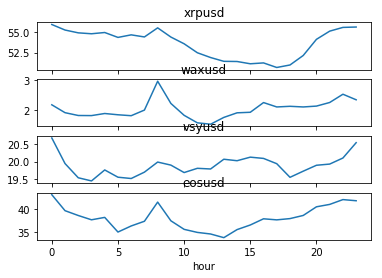

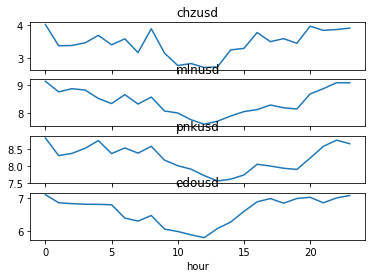

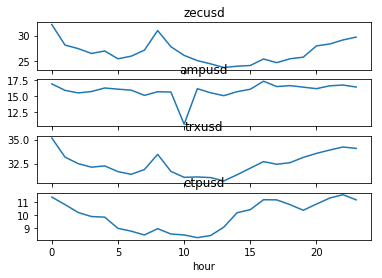

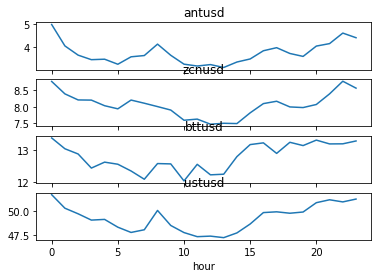

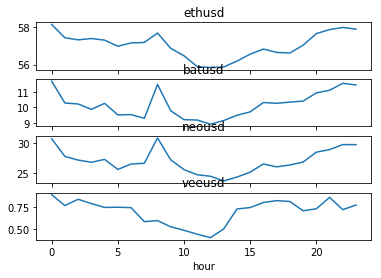

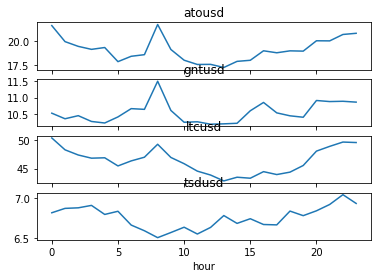

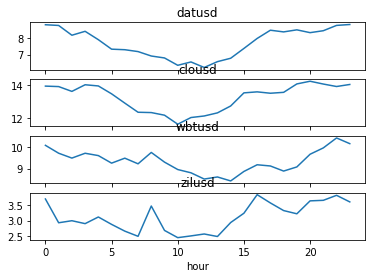

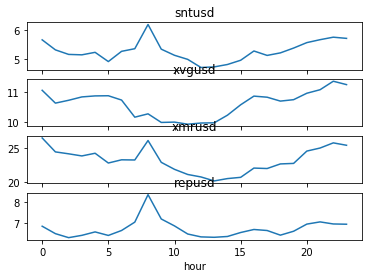

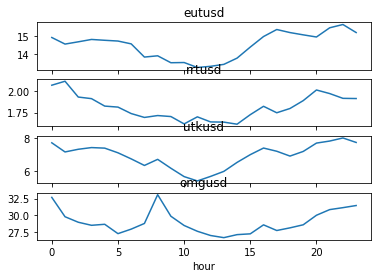

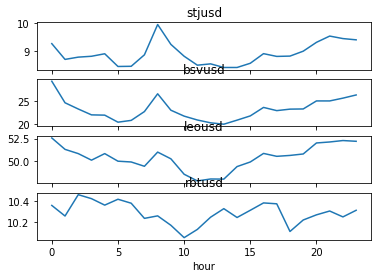

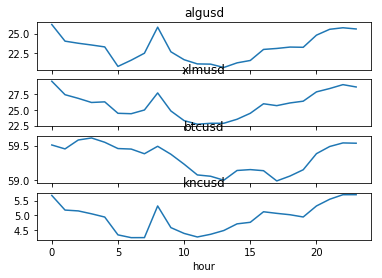

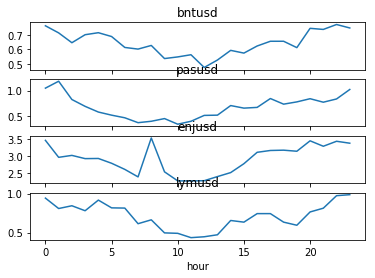

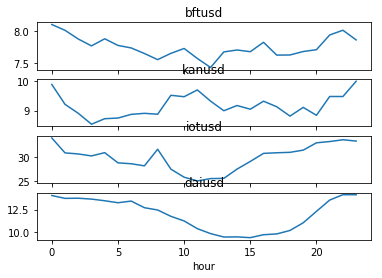

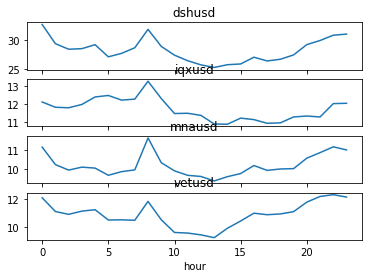

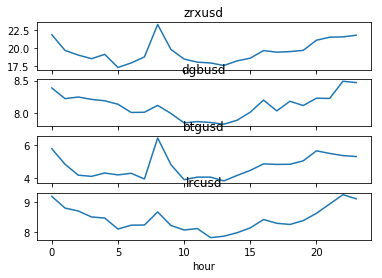

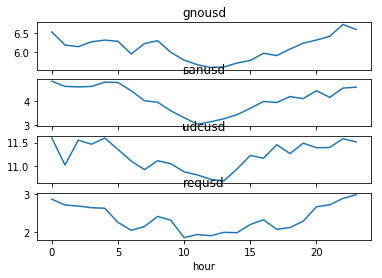

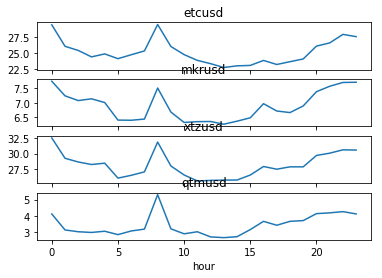

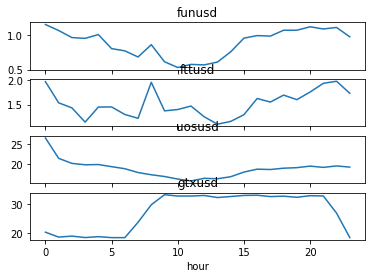

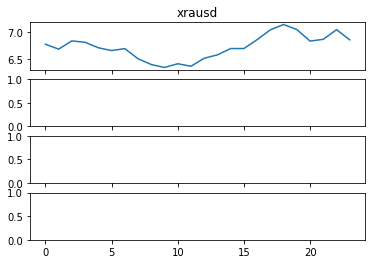

In [134]:
num_bars_in_1hr = {}
for i, row in tqdm(data_universe.iterrows()):
    # if i > 7:
    #     break
    if i % 4 == 0:
        fig, axes = plt.subplots(
            nrows=4, #data_universe.shape[0],
            ncols=1,
            sharex=True
        )
    df = pd.read_csv(f"data/{row.pair_name}.csv")
    df["time_key"] = df.time.apply(lambda x: datetime.fromtimestamp(int(x/1000)))
    df["date"] = df.time_key.apply(lambda x: x.date())
    df["hour"] = df.time_key.apply(lambda x: x.hour)
    df = df[
        (df.time_key >= "2020-01-01")
        & (df.time_key <= "2022-08-10")
    ]
    num_days = len(df.date.unique())
    # Average number of bars in that particular hour
    df1 = df.groupby("hour").count().time_key / num_days
    df1.plot(ax=axes[i%4], title=f"{row.pair_name}")
    num_bars_in_1hr[row.pair_name] = {
        "max": df1.max(),
        "min": df1.min(),
        "mean": df1.mean(),
        "median": df1.median(),
        "std": df1.std()
    }
num_bars_in_1hr = pd.DataFrame(num_bars_in_1hr).T
num_bars_in_1hr = num_bars_in_1hr.sort_values(by="min", ascending=False)
num_bars_in_1hr

We can see that `BTC` and `ETH` are trading most actively; while
coins such as `LYM` and `PAS` are almost inactive. The table shows
that there are 59 bars (1-min OHLCV) in every hour for `BTC`, and 57
bars for `ETH`, which indicates high liquidity for these two
cryptocurrencies. The less this number becomes, the more illiquidity
it means. Let's list the top 10 coins:


In [136]:
num_bars_in_1hr.head(10)

,max,min,mean,median,std
btcusd,59.608604,58.991605,59.324764,59.382476,0.206336
ethusd,58.116474,55.850997,57.024397,57.084995,0.669325
xrpusd,55.938090,50.664218,53.606156,54.376180,1.792253
leousd,52.563484,47.875131,50.418372,50.608604,1.350630
ustusd,51.694648,47.248688,49.271030,49.426023,1.373168
ltcusd,50.429171,42.803778,46.394281,46.599161,2.267764
eosusd,43.192025,33.854145,38.120322,37.842078,2.586378
trxusd,35.163866,30.692227,32.464636,32.341912,1.172689
omgusd,33.095588,26.596639,28.966737,28.537290,1.795630
xtzusd,32.525708,25.580273,28.096450,27.885624,1.992050


As we can see, only the first 6 pairs are sufficient liquid (with
more than 45 bars in an hour). There is a big gap between `LTC`
and `EOS`. In order to guarantee the liquidity of trading
instruments, we limit our trading universe to the top 6 cryptocurrency
pairs, i.e., `BTCUSD`, `ETHUSD`, `XRPUSD`, `LEOUSD`, `USTUSD`,
and `LTCUSD`.

We can take a closer look at these coins:

0 0 btcusd
1 1 ethusd
2 0 xrpusd
3 1 leousd
4 0 ustusd
5 1 ltcusd


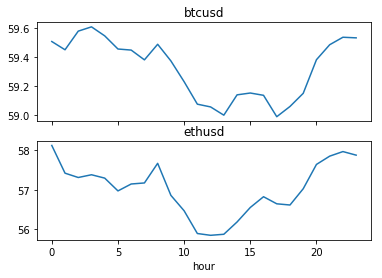

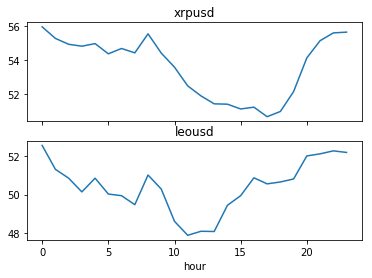

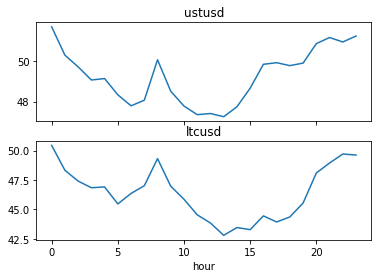

In [148]:
pairs = {
    "btcusd": None,
    "ethusd": None,
    "xrpusd": None,
    "leousd": None,
    "ustusd": None,
    "ltcusd": None
}
for i, pair_name in enumerate(pairs):
    print(i, i%2, pair_name)
    if i % 2 == 0:
        fig, axes = plt.subplots(
            nrows=2, #data_universe.shape[0],
            ncols=1,
            sharex=True
        )
    df = pd.read_csv(f"data/{pair_name}.csv")
    df["time_key"] = df.time.apply(lambda x: datetime.fromtimestamp(int(x/1000)))
    df["date"] = df.time_key.apply(lambda x: x.date())
    df["hour"] = df.time_key.apply(lambda x: x.hour)
    df = df[
        (df.time_key >= "2020-01-01")
        & (df.time_key <= "2022-08-10")
    ]
    pairs[pair_name] = df.copy()
    num_days = len(df.date.unique())
    # Average number of bars in that particular hour
    df1 = df.groupby("hour").count().time_key / num_days
    df1.plot(ax=axes[i%2], title=f"{pair_name}")

As we can see, all the six pairs have similar active trading
hours. The market is relatively scilent during 9 am to 4 pm.
This may indicate that the investors of different cryptocurrencies
are likely the same group of people.

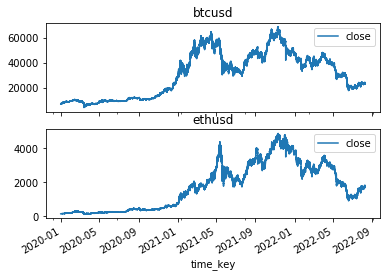

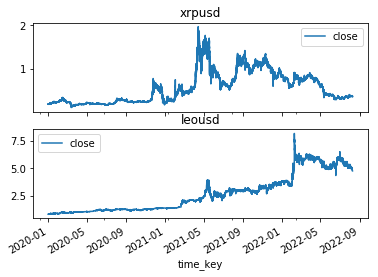

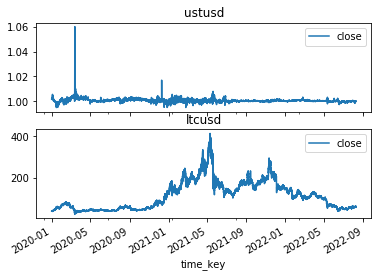

In [161]:
for i, pair_name in enumerate(pairs):
    if i % 2 == 0:
        fig, axes = plt.subplots(
            nrows=2, #data_universe.shape[0],
            ncols=1,
            sharex=True
        )
    df = pairs[pair_name]
    df[["time_key", "close"]].set_index("time_key").plot(
        ax=axes[i%2],
        title=pair_name)